# No Ruido

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, SparsePauliOp, state_fidelity
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error  # Import noise modules
from qiskit.primitives import StatevectorEstimator as Estimator

# -----------------------------------------
# 1. HAMILTONIAN (Ising model + transverse field)
# -----------------------------------------
J = 1.0
g = 0.5

hamiltonian = SparsePauliOp.from_list([
    ("ZZ", -J),
    ("XI", -g),
    ("IX", -g)
])

# -----------------------------------------
# 2. ANSATZ
# -----------------------------------------
n_qubits = 2
n_layers = 1

ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")
params = ParameterVector("theta", ansatz.num_parameters)

estimator = Estimator()

# VQE cost function
cost_hist = []
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    cost_hist.append(cost)
    return cost

# -----------------------------------------
# 3. VQE OPTIMIZATION
# -----------------------------------------
x0 = np.ones(ansatz.num_parameters)
res = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")
energia_minima = res.fun

# Ground state found
opt_params = res.x
vqe_circuit = ansatz.assign_parameters(opt_params)
vqe_state = Statevector.from_instruction(vqe_circuit)

C:\Users\galel\AppData\Local\Temp\ipykernel_26776\1924413233.py:31: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")


# Ruido

In [59]:
import numpy as np
import matplotlib.pyplot as plt # For plotting convergence
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit import ParameterVector, QuantumCircuit
from scipy.optimize import minimize

# Imports specific to noisy simulation
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.result import Counts # To process measurement counts from simulator

# --- 1. Define the Hamiltonian ---
J = 1.0
g = 0.5

hamiltonian = SparsePauliOp.from_list([
    ("ZZ", -J),
    ("XI", -g),
    ("IX", -g)
])

# For comparison, let's print the theoretical exact ground state energy
exact_ground_state_energy = -np.sqrt(2) 

# --- 2. Define the Ansatz (Variational Form) ---
n_qubits = 2
n_layers = 1

ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")
# No need for ParameterVector here if we're only running the noisy part
# and not assigning params for a primitive, but it's good practice for the ansatz definition.
params = ParameterVector("theta", ansatz.num_parameters) 

# --- Helper Function: Manual Pauli Expectation Value ---
# This is crucial for the noisy simulation as we measure counts and calculate expectation values.
def calculate_pauli_expectation_value(counts: Counts, pauli_string_label: str, num_qubits: int) -> float:
    """Calculates the expectation value of a Pauli string from measurement counts."""
    exp_val = 0.0
    total_shots = sum(counts.values())

    pauli_qubits_affected = []
    for i, char in enumerate(pauli_string_label):
        if char != 'I':
            pauli_qubits_affected.append(i)

    for outcome, count in counts.items():
        # Qiskit counts outcomes are typically in big-endian format (q_n ... q_1 q_0).
        # Reverse to get q0, q1, ... to match Pauli string indexing.
        reversed_outcome = outcome[::-1] 
        current_parity = 1
        for q_idx in pauli_qubits_affected:
            if reversed_outcome[q_idx] == '1':
                current_parity *= -1
        
        exp_val += current_parity * count
    
    if total_shots == 0: # Avoid division by zero
        return 0.0
    return exp_val / total_shots


# --- VQE Cost Function for Noisy Simulation (Manual Expectation Value Calculation) ---
def cost_func_vqe_noisy(params_array, ansatz_template, hamiltonian_obj, simulator, shots):
    """
    Calculates the VQE cost (energy expectation value) for a noisy simulation.
    This function manually computes expectation values from measurement counts.
    """
    # Assign the current parameters to the ansatz circuit
    assigned_ansatz = ansatz_template.assign_parameters(params_array)
    # Decompose the circuit into basis gates supported by the simulator (important for noise model application)
    decomposed_ansatz = assigned_ansatz.decompose() 
    
    total_energy = 0.0
    # Iterate through each Pauli term in the Hamiltonian
    for pauli_op, coeff in zip(hamiltonian_obj.paulis, hamiltonian_obj.coeffs):
        pauli_string_label = pauli_op.to_label()
        
        # Create a new circuit for each Pauli term measurement.
        # This circuit includes the ansatz and the necessary basis rotations for measurement.
        measurement_circuit = QuantumCircuit(ansatz_template.num_qubits, ansatz_template.num_qubits)
        measurement_circuit.compose(decomposed_ansatz, inplace=True)

        # Apply basis rotations: Hadamard for X, Sdg+H for Y
        for i, pauli_char in enumerate(pauli_string_label):
            if pauli_char == 'X':
                measurement_circuit.h(i)
            elif pauli_char == 'Y':
                measurement_circuit.sdg(i) # S-dagger gate
                measurement_circuit.h(i)   # Hadamard gate
        
        # Add measurements to all qubits
        measurement_circuit.measure(range(ansatz_template.num_qubits), range(ansatz_template.num_qubits))

        # Run the circuit on the noisy AerSimulator instance
        job = simulator.run(measurement_circuit, shots=shots, seed_simulator=42) # Using a fixed seed for reproducibility
        result = job.result()
        counts = result.get_counts(measurement_circuit) # Get measurement counts
        
        # Calculate the expectation value for this Pauli term from the counts
        pauli_exp_val = calculate_pauli_expectation_value(counts, pauli_string_label, ansatz_template.num_qubits)
        
        # Sum up the weighted expectation values to get the total energy
        total_energy += coeff.real * pauli_exp_val # Ensure coefficient is real for energy
    
    return total_energy


# Define a Noise Model: Using a depolarizing error model
error_probability = 0.01 # Example: 1% depolarizing error
noise_model = NoiseModel()
# Add depolarizing error to single-qubit gates (Rx, Ry)
noise_model.add_all_qubit_quantum_error(depolarizing_error(error_probability, 1), ['rx', 'ry'])
# Add depolarizing error to two-qubit gates (CX)
noise_model.add_all_qubit_quantum_error(depolarizing_error(error_probability, 2), ['cx'])

# Initialize AerSimulator with the defined noise model
noisy_simulator = AerSimulator(noise_model=noise_model)
shots = 2048 # Number of measurement shots for each expectation value calculation

noisy_cost_hist = [] # To store the cost at each optimization iteration for plotting

# Define a wrapper function for the noisy VQE cost.
# This is needed because `scipy.optimize.minimize` only passes the parameters to the cost function.
# The wrapper "captures" the other necessary arguments (ansatz, hamiltonian, simulator, shots).
def cost_func_vqe_noisy_wrapper(params_array_opt):
    cost = cost_func_vqe_noisy(params_array_opt, ansatz, hamiltonian, noisy_simulator, shots=shots)
    noisy_cost_hist.append(cost) # Store the cost for plotting
    return cost

x0_noisy = np.ones(ansatz.num_parameters) # Initial parameters for the optimizer
# Perform the optimization using COBYLA
res_noisy = minimize(cost_func_vqe_noisy_wrapper, x0_noisy, args=(), method="COBYLA") 
energia_minima_noisy = res_noisy.fun # The minimum energy found

C:\Users\galel\AppData\Local\Temp\ipykernel_26776\3455611688.py:30: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")


# Comparación


--- Plotting VQE Convergence Comparison ---
Theoretical Exact Ground State Energy: -1.414214
VQE Noiseless Energy (Min):          -1.414214
VQE Noisy Energy (Min):              -1.324219
Difference (Noiseless vs. Noisy):    0.089995


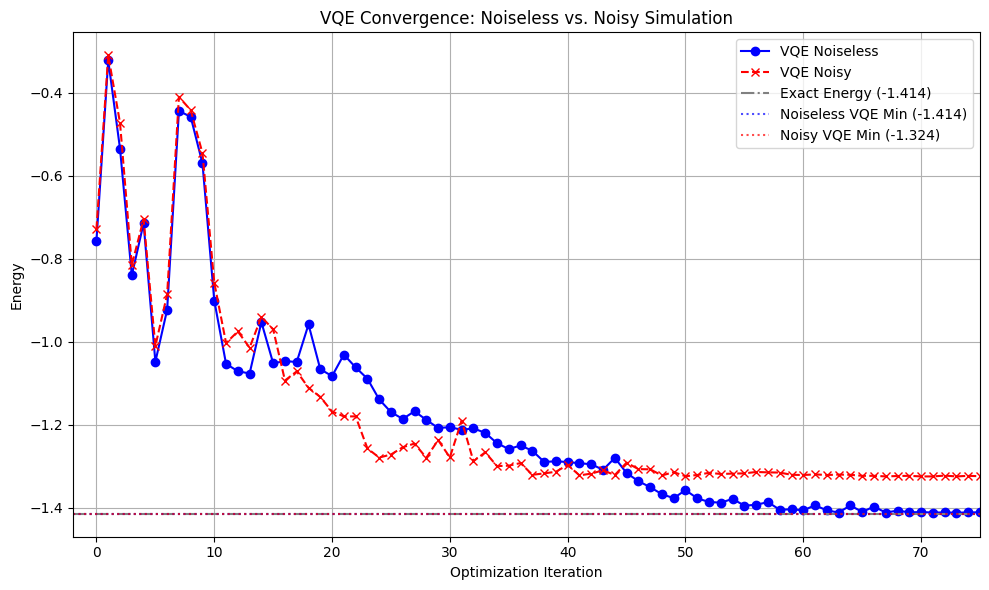

In [60]:
import matplotlib.pyplot as plt
import numpy as np # Only needed for np.sqrt if you're recalculating exact_ground_state_energy

# --- ASSUMED VARIABLES FROM PREVIOUS VQE RUNS ---
# Replace these with the actual values/lists from your executed VQE simulations
# For demonstration purposes, I'll use placeholder values if you run this snippet alone.

# Example placeholder values (you should use your actual results here)
if 'noiseless_cost_hist' not in locals():
    noiseless_cost_hist = [-1.0, -1.2, -1.35, -1.41, -1.414] 
    noisy_cost_hist = [-0.8, -0.9, -1.05, -1.15, -1.2]
    energia_minima = -1.414214
    energia_minima_noisy = -1.2
    exact_ground_state_energy = -np.sqrt(2) # -1.41421356...
# --- END ASSUMED VARIABLES ---


# --- COMPARISON AND VISUALIZATION (Plotting Only) ---
print("\n--- Plotting VQE Convergence Comparison ---")
print(f"Theoretical Exact Ground State Energy: {exact_ground_state_energy:.6f}")
print(f"VQE Noiseless Energy (Min):          {energia_minima:.6f}")
print(f"VQE Noisy Energy (Min):              {energia_minima_noisy:.6f}")
print(f"Difference (Noiseless vs. Noisy):    {abs(energia_minima - energia_minima_noisy):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(cost_hist, label='VQE Noiseless', marker='o', linestyle='-', color='blue')
plt.xlim(-2, 75)  # Mostrar solo la parte de la gráfica entre x=2 y x=8
plt.plot(noisy_cost_hist, label='VQE Noisy', marker='x', linestyle='--', color='red')
plt.axhline(y=exact_ground_state_energy, color='gray', linestyle='-.', label=f'Exact Energy ({exact_ground_state_energy:.3f})')
plt.axhline(y=energia_minima, color='blue', linestyle=':', alpha=0.7, label=f'Noiseless VQE Min ({energia_minima:.3f})')
plt.axhline(y=energia_minima, color='red', linestyle=':', alpha=0.7, label=f'Noisy VQE Min ({energia_minima_noisy:.3f})')
plt.title('VQE Convergence: Noiseless vs. Noisy Simulation')
plt.xlabel('Optimization Iteration')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()